## Machine Learning Example - Time Series SVR and Random Forest Regressor

- Name: Germán Hilgert
- LinkedIn: https://www.linkedin.com/in/german-hilgert/
- Date: 23/10/22

# Análisis de series de tiempo 

Las series de tiempo son una secuencia de observaciones indexadas por una variable temporal. Una de las aplicaciones más comunes del análisis de series de tiempo es la predicción de valores futuros utilizando datos históricos. Por ejemplo se desea predecir el valor de la medida en el siguiente minuto, día, mes, año basados en los datos recolectados en el/(los) minuto(s), día(s), mese(s) y años previo(s). 


![texto alternativo](https://cdn-images-1.medium.com/max/800/1*ScwIEwLmXPFhBP46QMpy_A.png)

## Series de tiempo como problema supervisado 

Un problema de análisis de series de tiempo puede ser transformado en un problema de aprendizaje supervisado tomando una **ventana** de  las *n* observaciones anteriores como los predictores y el valor actual como el valor objetivo o valor explicado. El ancho de la ventana *n* normalmente se explora como hiperparámetro. 

## Validación cruzada para series de tiempo

Un aspecto importante a tener en cuenta en el análisis de series de tiempo es que la selección de los conjuntos de validación y entrenamiento para la validación cruzada (*Cross-validation*) no puede ser aleatorio como se realiza en otros problemas de machine learning supervisado donde la secuencia y el tiempo no se toman en cuenta. En el análisis de series de tiempo estamos interesados en predecir un valor en el futuro, de esta manera los datos de validación para series de tiempo siempre deben ocurrir después de los datos de entrenamiento. Existen dos esquemas de validación cruzada para series de tiempo **sliding-window** y **Forward chaining validation** que pueden ser usados para la validación cruzada de series de tiempo.

![texto alternativo](https://cdn-images-1.medium.com/max/800/1*h6HaTi1DKsNqEUjdECQV0A.png)



## Demostración 

Ahora realizaremos la predicción para el dataset S&P 500, que es el indice de capitalización de Standard & Poor's compuesto por las 500 empresas  pricipales que cotizan acciones en los mercados NYSE y NASDAQ, estos datos fueron tomados de la siguiente dirección https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC.

#### Iniciamos por la carga de datos 

Vamos a cargar el dataset en un pandas dataframe. Y a visualizar sus primeras 4 filas.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("data/GSPC.csv")
df.head(4)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1995-01-01,459.209991,471.359985,457.200012,470.420013,470.420013,6852060000
1,1995-02-01,470.420013,489.190002,469.290009,487.390015,487.390015,6330100000
2,1995-03-01,487.390015,508.149994,479.700012,500.709991,500.709991,7792400000
3,1995-04-01,500.700012,515.289978,500.200012,514.710022,514.710022,6307030000


El dataset cuenta con una columna que muestra la fecha (Date) calculada el primer día de cada mes, el valor del indice a la apertura (Open) del mercado, el valor máximo alcanzado durante la jornada (High), el valor mínimo alcanzado durante la jornada (Low), y el valor del indice al final de la jornada (Close), el valor de cierre ajustado (Adj Close) y volumen de transacciones (Volume).

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       267 non-null    object 
 1   Open       267 non-null    float64
 2   High       267 non-null    float64
 3   Low        267 non-null    float64
 4   Close      267 non-null    float64
 5   Adj Close  267 non-null    float64
 6   Volume     267 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 14.7+ KB


Antes de continuar con el análisis debemos establecer las fechas como índice del data frame. 

In [4]:
df.sort_values('Date', inplace=True)
df = df.set_index("Date")
df.head(4)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-01-01,459.209991,471.359985,457.200012,470.420013,470.420013,6852060000
1995-02-01,470.420013,489.190002,469.290009,487.390015,487.390015,6330100000
1995-03-01,487.390015,508.149994,479.700012,500.709991,500.709991,7792400000
1995-04-01,500.700012,515.289978,500.200012,514.710022,514.710022,6307030000


Vamos a visualizar la serie de los valores del índice.

<AxesSubplot:xlabel='Date'>

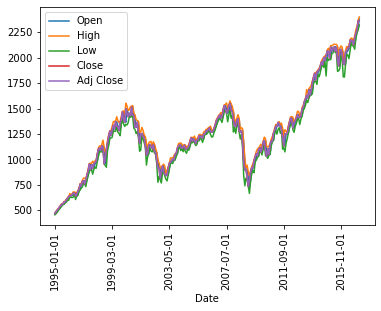

In [5]:
df[["Open", "High", "Low", "Close", "Adj Close"]].plot(rot=90)

Visualizamos la serie de apertura que será el valor que predeciremos.

<AxesSubplot:xlabel='Date'>

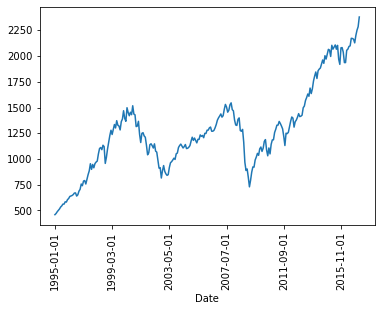

In [6]:
df["Open"].plot(rot=90)

Vamos a construir el dataset, las features serán las n observaciones previas y el valor a predecir será el valor actual. Vamos a iniciar con una ventana de tiempo de 3 observaciones.

In [7]:
X = df[['Open']]
X

,Open
Date,
1995-01-01,459.209991
1995-02-01,470.420013
1995-03-01,487.390015
1995-04-01,500.700012
1995-05-01,514.760010
...,...
2016-11-01,2128.679932
2016-12-01,2200.169922
2017-01-01,2251.570068


In [8]:
#Para obtener los valores de la variable pero dias anteriores.
X['Open-1'] = X['Open'].shift(1)
X['Open-2'] = X['Open'].shift(2)
X['Open-3'] = X['Open'].shift(3)
X['Open-4'] = X['Open'].shift(4)
X['Open-5'] = X['Open'].shift(5)
X

,Open,Open-1,Open-2,Open-3,Open-4,Open-5
Date,,,,,,
1995-01-01,459.209991,NaN,NaN,NaN,NaN,NaN
1995-02-01,470.420013,459.209991,NaN,NaN,NaN,NaN
1995-03-01,487.390015,470.420013,459.209991,NaN,NaN,NaN
1995-04-01,500.700012,487.390015,470.420013,459.209991,NaN,NaN
1995-05-01,514.760010,500.700012,487.390015,470.420013,459.209991,NaN
...,...,...,...,...,...,...
2016-11-01,2128.679932,2164.330078,2171.330078,2173.149902,2099.340088,2093.939941
2016-12-01,2200.169922,2128.679932,2164.330078,2171.330078,2173.149902,2099.340088
2017-01-01,2251.570068,2200.169922,2128.679932,2164.330078,2171.330078,2173.149902


### Ingeniería de variables

In [9]:
X.reset_index(inplace=True)

In [10]:
X.dtypes

Date       object
Open      float64
Open-1    float64
Open-2    float64
Open-3    float64
Open-4    float64
Open-5    float64
dtype: object

In [11]:
X['Date'] = pd.to_datetime(X['Date'])

In [12]:
X['Año'] = X['Date'].dt.year
X['Mes'] = X['Date'].dt.month
X['Dia'] = X['Date'].dt.day
X['Dia_semana'] = X['Date'].dt.weekday

X.set_index("Date", inplace=True)
X

,Open,Open-1,Open-2,Open-3,Open-4,Open-5,Año,Mes,Dia,Dia_semana
Date,,,,,,,,,,
1995-01-01,459.209991,NaN,NaN,NaN,NaN,NaN,1995,1,1,6
1995-02-01,470.420013,459.209991,NaN,NaN,NaN,NaN,1995,2,1,2
1995-03-01,487.390015,470.420013,459.209991,NaN,NaN,NaN,1995,3,1,2
1995-04-01,500.700012,487.390015,470.420013,459.209991,NaN,NaN,1995,4,1,5
1995-05-01,514.760010,500.700012,487.390015,470.420013,459.209991,NaN,1995,5,1,0
...,...,...,...,...,...,...,...,...,...,...
2016-11-01,2128.679932,2164.330078,2171.330078,2173.149902,2099.340088,2093.939941,2016,11,1,1
2016-12-01,2200.169922,2128.679932,2164.330078,2171.330078,2173.149902,2099.340088,2016,12,1,3
2017-01-01,2251.570068,2200.169922,2128.679932,2164.330078,2171.330078,2173.149902,2017,1,1,6


In [13]:
# Ahora quitamos los que tienen datos nulos, por lo que no se puede ver la serie de tiempo completa
X.dropna(inplace=True)
X

,Open,Open-1,Open-2,Open-3,Open-4,Open-5,Año,Mes,Dia,Dia_semana
Date,,,,,,,,,,
1995-06-01,533.400024,514.760010,500.700012,487.390015,470.420013,459.209991,1995,6,1,3
1995-07-01,544.750000,533.400024,514.760010,500.700012,487.390015,470.420013,1995,7,1,5
1995-08-01,562.059998,544.750000,533.400024,514.760010,500.700012,487.390015,1995,8,1,1
1995-09-01,561.880005,562.059998,544.750000,533.400024,514.760010,500.700012,1995,9,1,4
1995-10-01,584.409973,561.880005,562.059998,544.750000,533.400024,514.760010,1995,10,1,6
...,...,...,...,...,...,...,...,...,...,...
2016-11-01,2128.679932,2164.330078,2171.330078,2173.149902,2099.340088,2093.939941,2016,11,1,1
2016-12-01,2200.169922,2128.679932,2164.330078,2171.330078,2173.149902,2099.340088,2016,12,1,3
2017-01-01,2251.570068,2200.169922,2128.679932,2164.330078,2171.330078,2173.149902,2017,1,1,6


In [14]:
y = X['Open']
X.drop(columns=['Open'], inplace=True)

In [15]:
print("Número de ejemplos de entrenamiento {}, número de features {}".format(X.shape[0], X.shape[1]))
print("Número de valores a predecir {}".format(y.shape))

Número de ejemplos de entrenamiento 262, número de features 9
Número de valores a predecir (262,)


Como pudimos observar el número de ejemplos son 262, tres ejemplos menos que en la serie original, esto es debido a que las primeras siete muestras no cuentan con features suficientes para ser incluidas dentro del conjunto de datos para el entrenamiento de los modelos. 

In [16]:
# La partición de los datos se realiza con base en el tiempo
from sklearn.model_selection import TimeSeriesSplit

In [17]:
X.shape, y.shape

((262, 9), (262,))

In [18]:
# Definimos el número de splits para realizar cross-validation
tsp = TimeSeriesSplit(n_splits=2)
# La partición nos devuelve los indices de train y test
split1_idx, split2_idx = tsp.split(X, y)
print(split1_idx)
print(split2_idx)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87]), array([ 88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174]))
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  2

In [19]:
# Indexamos para obtener los conjuntos de train y test 
X_train = X.iloc[split2_idx[0]]
y_train = y.iloc[split2_idx[0]]
X_test = X.iloc[split2_idx[1]]
y_test = y.iloc[split2_idx[1]]

In [20]:
X_train

,Open-1,Open-2,Open-3,Open-4,Open-5,Año,Mes,Dia,Dia_semana
Date,,,,,,,,,
1995-06-01,514.760010,500.700012,487.390015,470.420013,459.209991,1995,6,1,3
1995-07-01,533.400024,514.760010,500.700012,487.390015,470.420013,1995,7,1,5
1995-08-01,544.750000,533.400024,514.760010,500.700012,487.390015,1995,8,1,1
1995-09-01,562.059998,544.750000,533.400024,514.760010,500.700012,1995,9,1,4
1995-10-01,561.880005,562.059998,544.750000,533.400024,514.760010,1995,10,1,6
...,...,...,...,...,...,...,...,...,...
2009-08-01,920.820007,923.260010,872.739990,793.590027,729.570007,2009,8,1,5
2009-09-01,990.219971,920.820007,923.260010,872.739990,793.590027,2009,9,1,1
2009-10-01,1019.520020,990.219971,920.820007,923.260010,872.739990,2009,10,1,3


In [21]:
# Verificamos los tamaños de train, validation y test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(175, 9)
(175,)
(87, 9)
(87,)


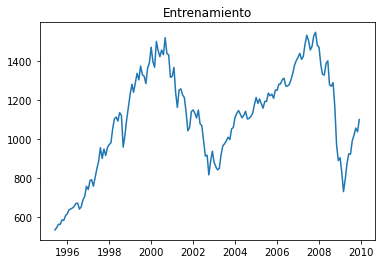

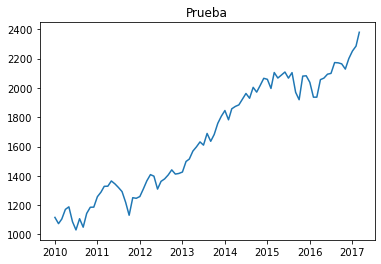

In [22]:
plt.plot(y_train)
plt.title("Entrenamiento")
plt.show()
plt.plot(y_test)
plt.title("Prueba")
plt.show()

### Modelo de regresión

In [23]:
from sklearn.svm import SVR

In [24]:
svr = SVR(C=4, kernel="linear")
svr.fit(X_train, y_train)

SVR(C=4, kernel='linear')

Evaluamos el modelo.

In [25]:
y_pred = svr.predict(X_test)

In [26]:
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error


print('R2', r2_score(y_test, y_pred))
print('mse', mean_squared_error(y_test, y_pred))
print('rmse', np.sqrt(mean_squared_error(y_test, y_pred)))
print('mae', mean_absolute_error(y_test, y_pred))

R2 0.978786310316746
mse 3132.511054375037
rmse 55.96884003063702
mae 45.09815725119501


#### Visualizamos los resultados 

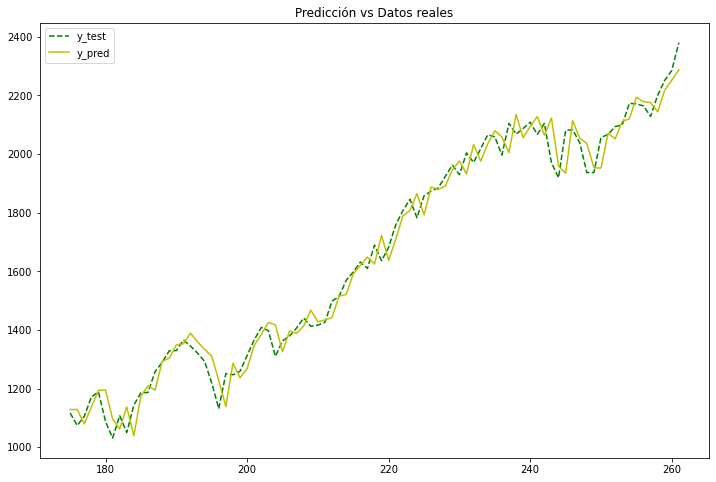

In [27]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test, "g--", 
         label="y_test")
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_pred, "y", 
         label="y_pred")
plt.title("Predicción vs Datos reales")
plt.legend()

Text(0, 0.5, 'Predicho')

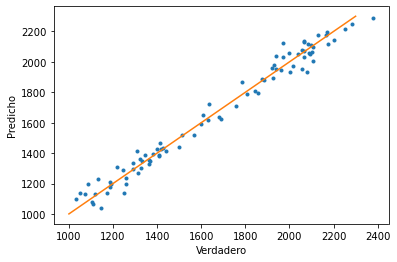

In [28]:
plt.plot(y_test, y_pred, '.')
plt.plot([1000,2300], [1000,2300])
plt.xlabel("Verdadero")
plt.ylabel("Predicho")

### Veamos otro caso

In [29]:
from sklearn.ensemble import RandomForestRegressor

rr = RandomForestRegressor(n_estimators=100)

In [30]:
rr.fit(X_train, y_train)

RandomForestRegressor()

In [31]:
y_pred = rr.predict(X_test)

In [32]:
print('R2', r2_score(y_test, y_pred))
print('mse', mean_squared_error(y_test, y_pred))
print('rmse', np.sqrt(mean_squared_error(y_test, y_pred)))
print('mae', mean_absolute_error(y_test, y_pred))

R2 -0.0776715939640753
mse 159133.94753498692
rmse 398.9159655052514
mae 297.06247344931063


#### Visualizamos los resultados 

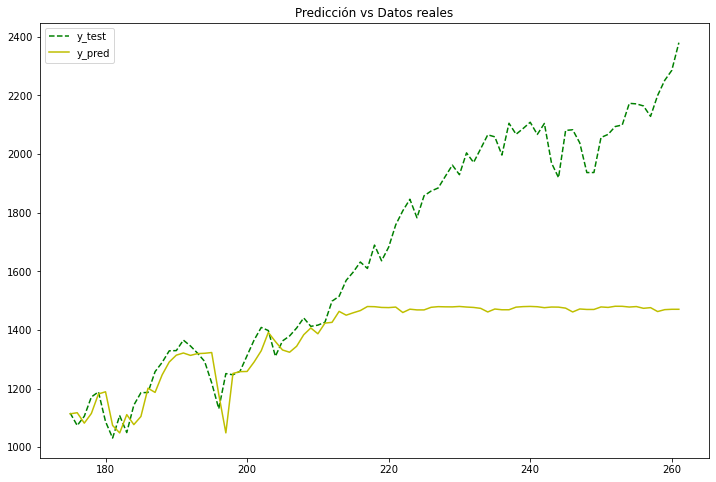

In [33]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test, "g--", 
         label="y_test")
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_pred, "y", 
         label="y_pred")
plt.title("Predicción vs Datos reales")
plt.legend()

Text(0, 0.5, 'Predicho')

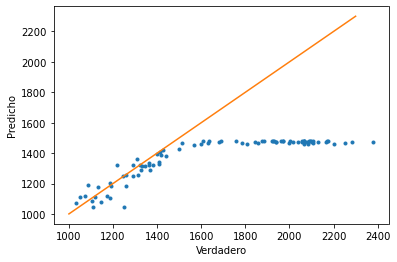

In [34]:
plt.plot(y_test, y_pred, '.')
plt.plot([1000,2300], [1000,2300])
plt.xlabel("Verdadero")
plt.ylabel("Predicho")

#### Modelo de regression - SOLO DATOS PREVIOS - SOLO UN PERIODO

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
# Hagamos nuestro primer experimento solo con los datos previos
X_train, X_test, y_train, y_test = train_test_split(X[['Open-1', 'Open-2', 'Open-3', 'Open-4', 'Open-5']], y, test_size=0.3, random_state=88)

In [37]:
# Verificamos los tamaños de train, validation y test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(183, 5)
(183,)
(79, 5)
(79,)


In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
rr = RandomForestRegressor(n_estimators=100)

In [40]:
rr.fit(X_train, y_train)

RandomForestRegressor()

In [41]:
y_pred = rr.predict(X_test)

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [43]:
print('R2', r2_score(y_test, y_pred))
print('mse', mean_squared_error(y_test, y_pred))
print('rmse', np.sqrt(mean_squared_error(y_test, y_pred)))
print('mae', mean_absolute_error(y_test, y_pred))

R2 0.9736154839019555
mse 4821.090337377392
rmse 69.43407187669028
mae 51.90413304493682


#### Visualizamos los resultados 

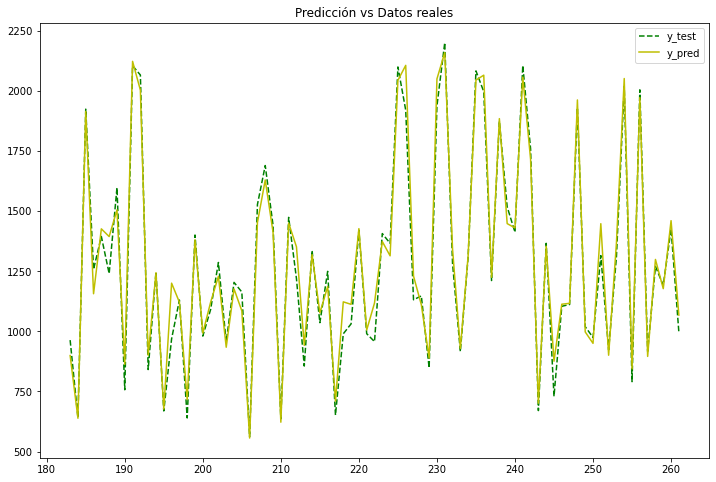

In [44]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test, "g--", 
         label="y_test")
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_pred, "y", 
         label="y_pred")
plt.title("Predicción vs Datos reales")
plt.legend()

Text(0, 0.5, 'Predicción')

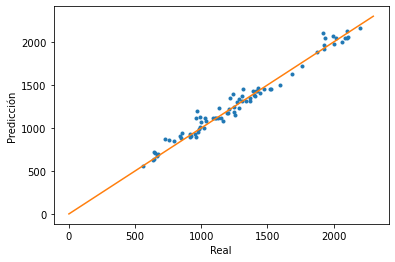

In [45]:
plt.plot(y_test, y_pred, '.')
plt.plot([0,2300], [0,2300])
plt.xlabel("Real")
plt.ylabel("Predicción")

### Modelo de regresión - TODOS LOS DATOS

In [46]:
# Hagamos nuestro segundo experimento con todas las variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

In [47]:
# Verificamos los tamaños de train, validation y test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(183, 9)
(183,)
(79, 9)
(79,)


In [48]:
rr = RandomForestRegressor(n_estimators=100)

In [49]:
rr.fit(X_train, y_train)

RandomForestRegressor()

In [50]:
y_pred = rr.predict(X_test)

In [51]:
print('R2', r2_score(y_test, y_pred))
print('mse', mean_squared_error(y_test, y_pred))
print('rmse', np.sqrt(mean_squared_error(y_test, y_pred)))
print('mae', mean_absolute_error(y_test, y_pred))

R2 0.9745062052339238
mse 4658.333969555786
rmse 68.25198875897892
mae 51.55946147924063


#### Visualizamos los resultados 

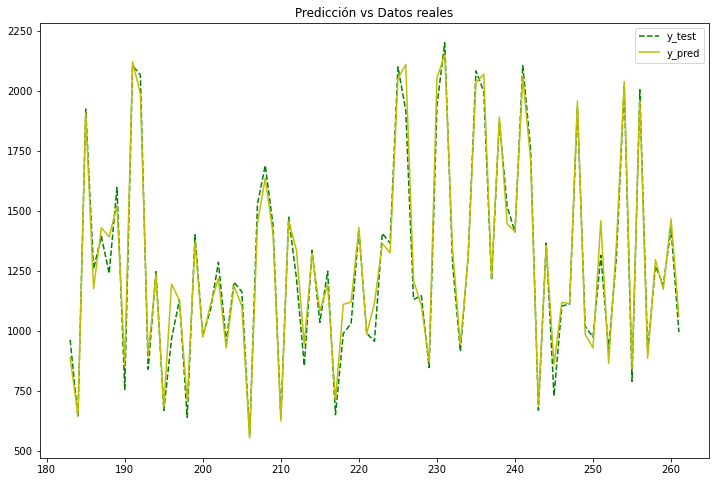

In [52]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test, "g--", 
         label="y_test")
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_pred, "y", 
         label="y_pred")
plt.title("Predicción vs Datos reales")
plt.legend()

Text(0, 0.5, 'Predicho')

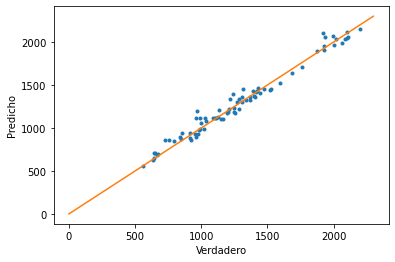

In [53]:
plt.plot(y_test, y_pred, '.')
plt.plot([0,2300], [0,2300])
plt.xlabel("Verdadero")
plt.ylabel("Predicho")

## Refrencias 

* https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a
* https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424
